In [151]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import collections

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Import Imputed Data

In [152]:
df = pd.read_csv('../data/imputed_data.csv')

In [153]:
df.head()

AirTemp  Azimuth  CloudOpacity  DewpointTemp  Dhi  Dni  Ebh  Ghi  \
0    15.30    157.5         81.90          13.3  0.0  0.0  0.0  0.0   
1    15.05   -170.5         81.65          13.2  0.0  0.0  0.0  0.0   
2    14.90   -143.0         61.40          13.0  0.0  0.0  0.0  0.0   
3    14.85   -128.0         76.25          14.5  0.0  0.0  0.0  0.0   
4    15.00   -120.0         85.30          14.5  0.0  0.0  0.0  0.0   

   GtiFixedTilt  GtiTracking  ...  EMS_total_load             DateTime  \
0           0.0          0.0  ...     7900.000000  2021-01-01 00:00:00   
1           0.0          0.0  ...     6820.000000  2021-01-01 01:00:00   
2           0.0          0.0  ...     6880.000000  2021-01-01 02:00:00   
3           0.0          0.0  ...     6550.000000  2021-01-01 03:00:00   
4           0.0          0.0  ...     4789.245683  2021-01-01 04:00:00   

        Day sin   Day cos  Week sin  Week cos  Year sin  Year cos  SinZenith  \
0 -6.012051e-12  1.000000  0.781831  0.623490  0.010881  0.999941  -0.061920   
1  2.588190e-01  0.965926  0.804598  0.593820  0.011597  0.999933  -0.999961   
2  5.000000e-01  0.866025  0.826239  0.563320  0.012314  0.999924  -0.962602   
3  7.071068e-01  0.707107  0.846724  0.532032  0.013031  0.999915   0.266657   
4  8.660254e-01  0.500000  0.866025  0.500000  0.013747  0.999905   0.742164   

   SinAzimuth  
0    0.408096  
1   -0.753912  
2    0.998345  
3   -0.721038  
4   -0.580611  

[5 rows x 29 columns]

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AirTemp            8760 non-null   float64
 1   Azimuth            8760 non-null   float64
 2   CloudOpacity       8760 non-null   float64
 3   DewpointTemp       8760 non-null   float64
 4   Dhi                8760 non-null   float64
 5   Dni                8760 non-null   float64
 6   Ebh                8760 non-null   float64
 7   Ghi                8760 non-null   float64
 8   GtiFixedTilt       8760 non-null   float64
 9   GtiTracking        8760 non-null   float64
 10  PrecipitableWater  8760 non-null   float64
 11  RelativeHumidity   8760 non-null   float64
 12  SurfacePressure    8760 non-null   float64
 13  Zenith             8760 non-null   float64
 14  AlbedoDaily        8760 non-null   float64
 15  Ppv1               8760 non-null   float64
 16  PrealL1            8760 

## Convert DateTime back to DateTime format

In [155]:
df['DateTime'] = pd.to_datetime(df.DateTime)

In [156]:
df.DateTime

0      2021-01-01 00:00:00
1      2021-01-01 01:00:00
2      2021-01-01 02:00:00
3      2021-01-01 03:00:00
4      2021-01-01 04:00:00
               ...        
8755   2021-12-31 19:00:00
8756   2021-12-31 20:00:00
8757   2021-12-31 21:00:00
8758   2021-12-31 22:00:00
8759   2021-12-31 23:00:00
Name: DateTime, Length: 8760, dtype: datetime64[ns]

## Plotting Setup

In [158]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [204]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  # Plot a forecast distribution against the 'true' time series.
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(15, 4))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = pd.date_range(
      x.iloc[num_steps_train],
      x.iloc[num_steps_train + num_steps_forecast - 1], freq='h')

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    # ax.xaxis.set_major_locator(x_locator)
    # ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [160]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  # Plot the contributions of posterior components in a single figure.
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(15, 1.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [161]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  #Plot a time series against a model's one-step predictions.

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(15, 4))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

## Lets try and forecast the last week of the data using the previous 4 weeks

In [162]:
num_forecast_steps = 24 * 7 # 1 week
training_data = df[-5*num_forecast_steps:-num_forecast_steps]

In [163]:
data = df[-5*num_forecast_steps:] # Last 5 weeks

In [164]:
data.head()

AirTemp  Azimuth  CloudOpacity  DewpointTemp  Dhi  Dni  Ebh  Ghi  \
7920     15.2    163.0         84.30          13.6  0.0  0.0  0.0  0.0   
7921     14.6   -160.5         76.75          13.3  0.0  0.0  0.0  0.0   
7922     14.5   -135.5         79.45          13.1  0.0  0.0  0.0  0.0   
7923     14.4   -122.5         63.90          13.0  0.0  0.0  0.0  0.0   
7924     14.4   -116.0         57.60          12.8  0.0  0.0  0.0  0.0   

      GtiFixedTilt  GtiTracking  ...  EMS_total_load            DateTime  \
7920           0.0          0.0  ...          3490.0 2021-11-27 00:00:00   
7921           0.0          0.0  ...          3070.0 2021-11-27 01:00:00   
7922           0.0          0.0  ...          3025.0 2021-11-27 02:00:00   
7923           0.0          0.0  ...          2900.0 2021-11-27 03:00:00   
7924           0.0          0.0  ...          2850.0 2021-11-27 04:00:00   

           Day sin   Day cos  Week sin  Week cos  Year sin  Year cos  \
7920 -1.358200e-11  1.000000  0.974928 -0.222521 -0.560830  0.827931   
7921  2.588190e-01  0.965926  0.965926 -0.258819 -0.560237  0.828333   
7922  5.000000e-01  0.866025  0.955573 -0.294755 -0.559643  0.828734   
7923  7.071068e-01  0.707107  0.943883 -0.330279 -0.559048  0.829135   
7924  8.660254e-01  0.500000  0.930874 -0.365341 -0.558454  0.829535   

      SinZenith  SinAzimuth  
7920  -0.079549   -0.354910  
7921  -0.079549    0.275178  
7922  -0.748068    0.399999  
7923  -0.942514   -0.022112  
7924  -0.829318   -0.236661  

[5 rows x 29 columns]

In [165]:
temperature = data.AirTemp
temperature

7920    15.20
7921    14.60
7922    14.50
7923    14.40
7924    14.40
        ...  
8755    16.25
8756    15.65
8757    15.30
8758    15.50
8759    15.50
Name: AirTemp, Length: 840, dtype: float64

<AxesSubplot: xlabel='DateTime', ylabel='Ppv1'>

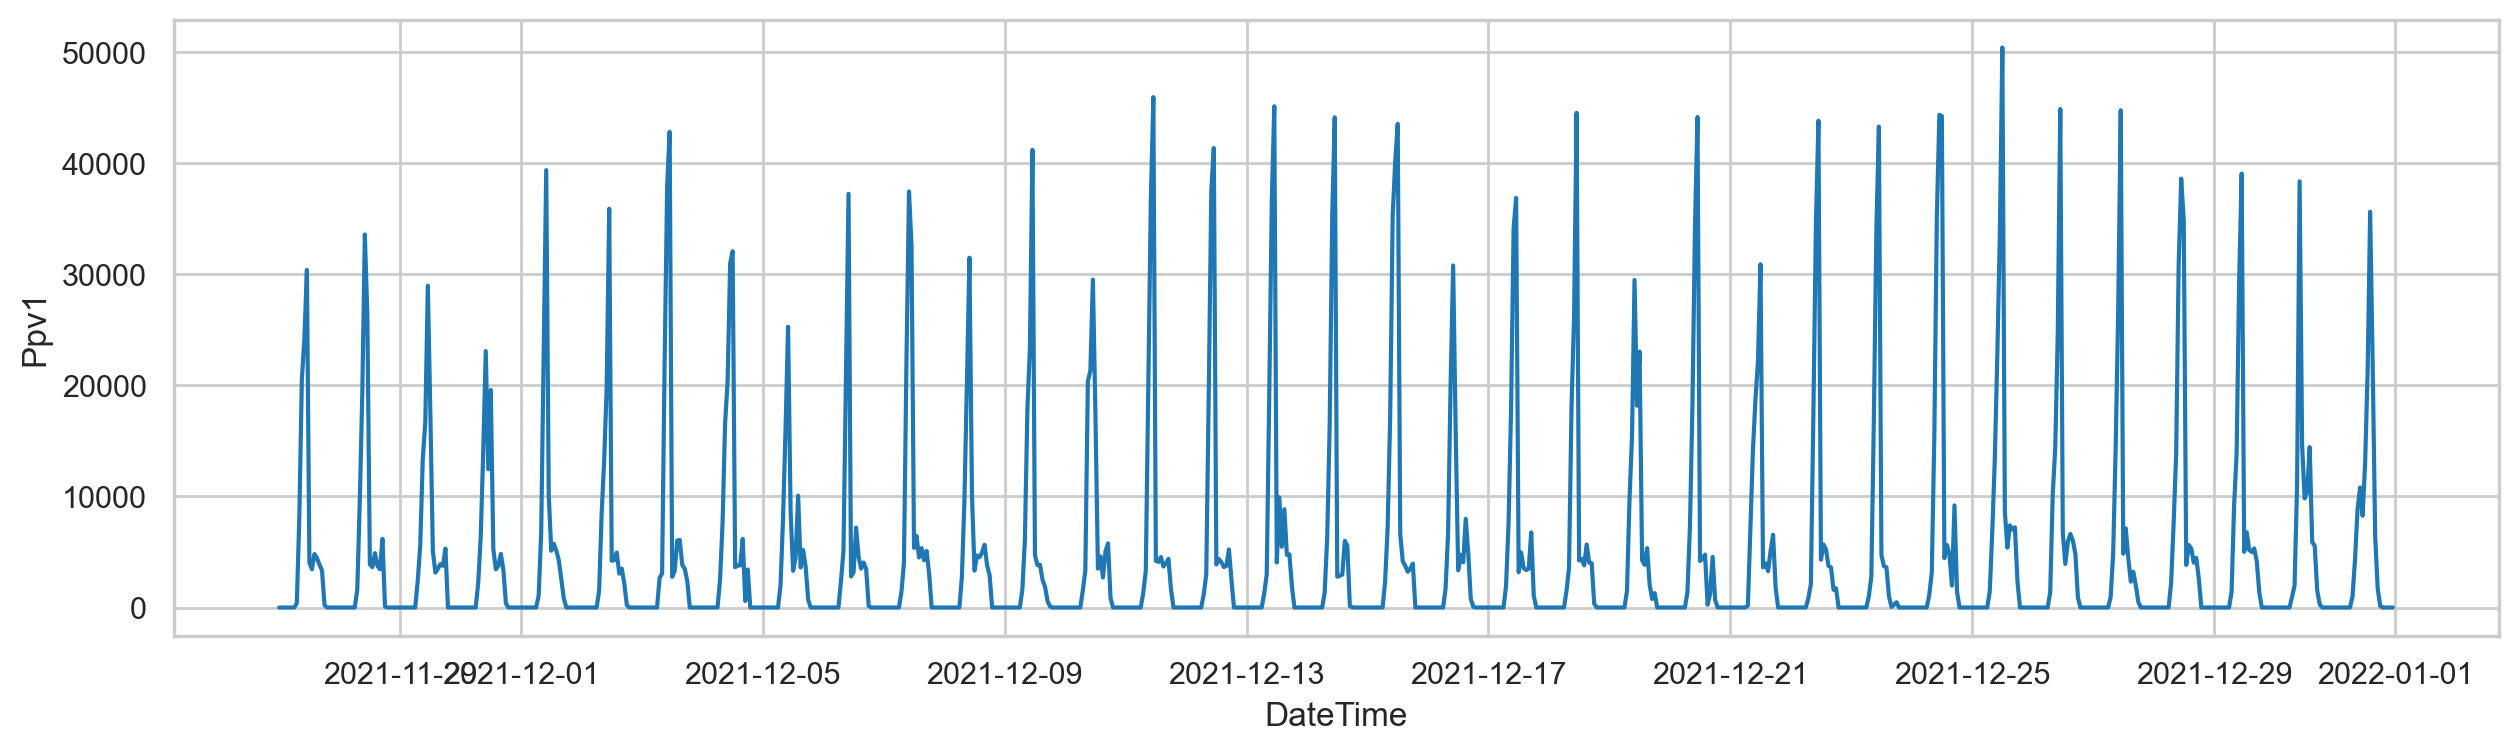

In [166]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = data.Ppv1)

<AxesSubplot: xlabel='DateTime', ylabel='CloudOpacity'>

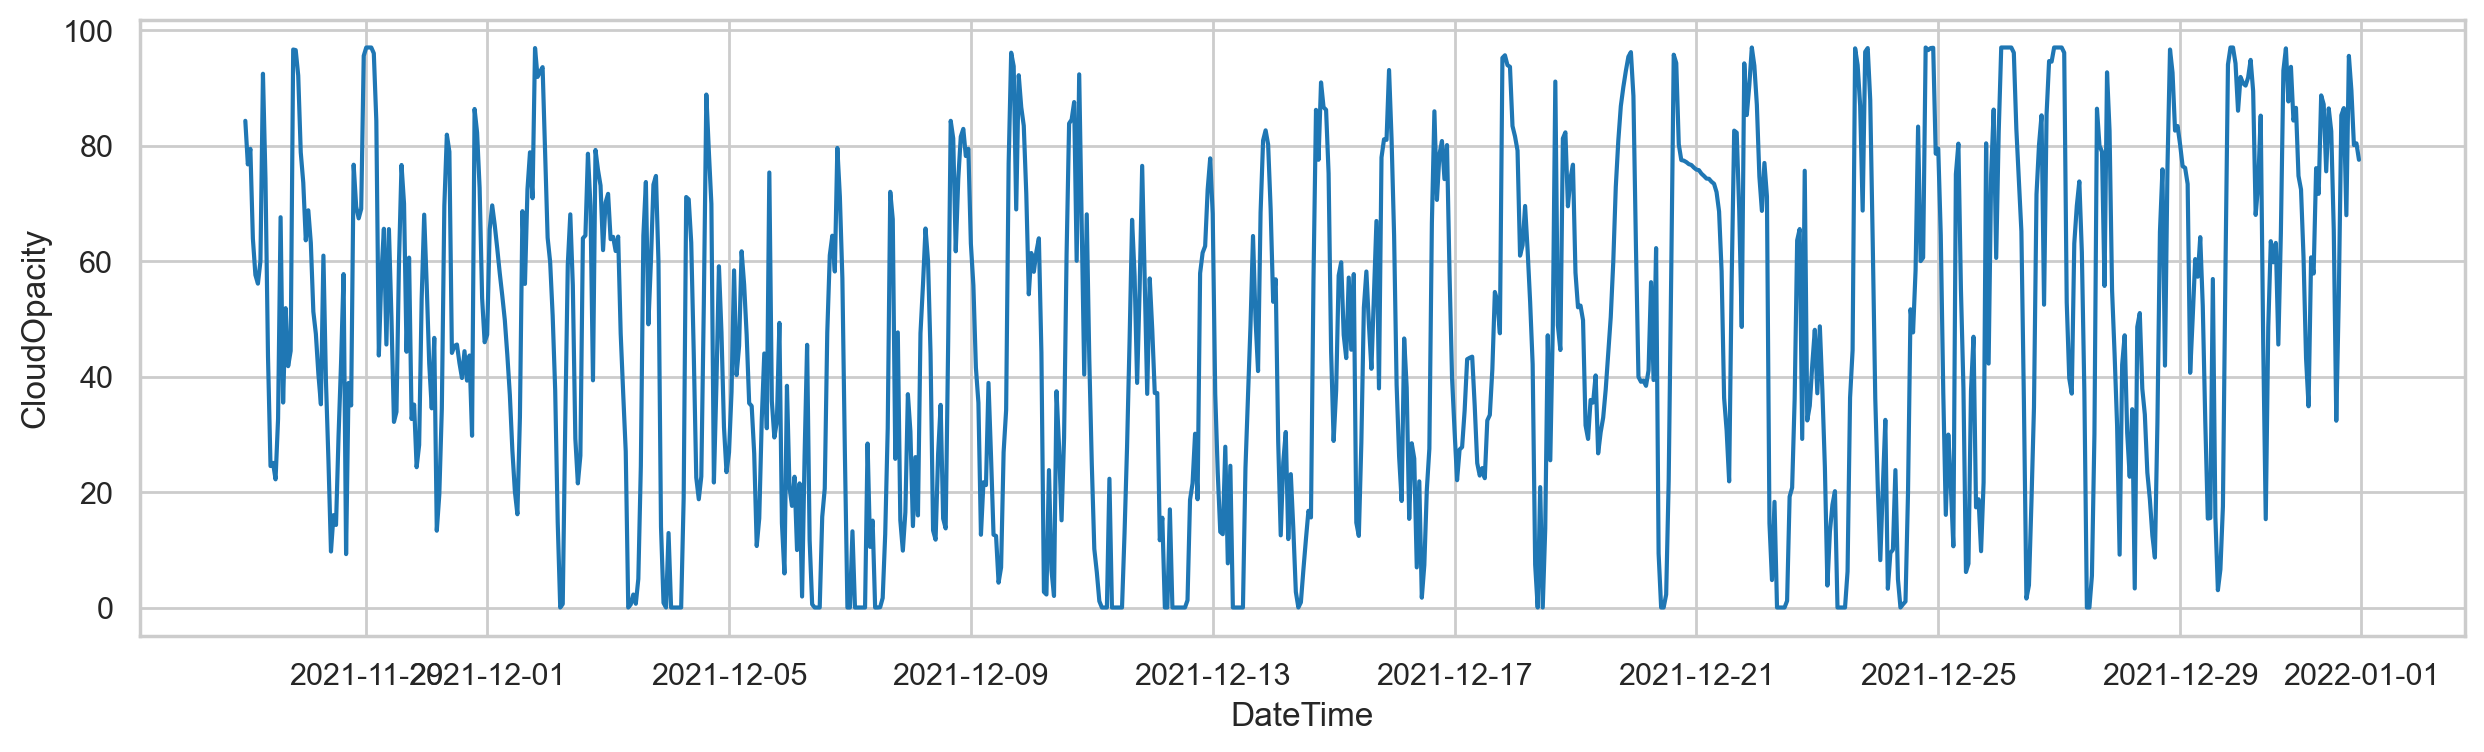

In [167]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = data.CloudOpacity)

<AxesSubplot: xlabel='DateTime', ylabel='Ghi'>

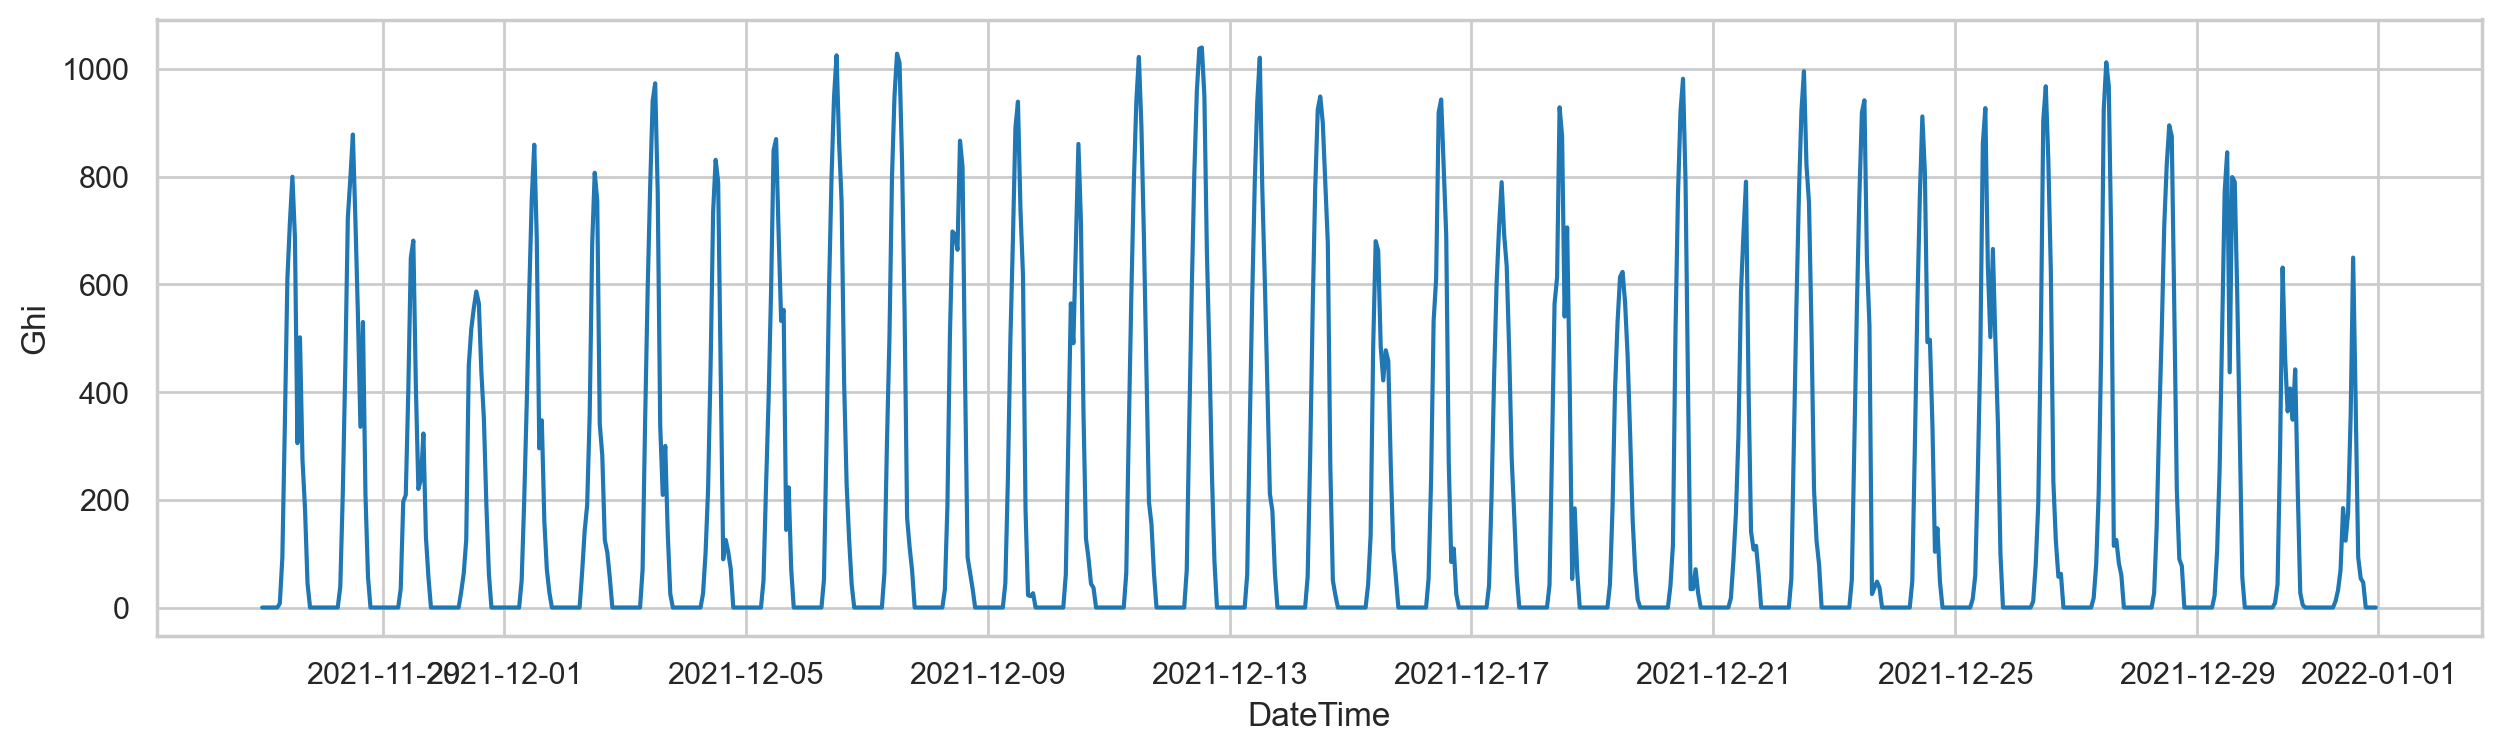

In [168]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = data.Ghi)

<AxesSubplot: xlabel='DateTime', ylabel='Ebh'>

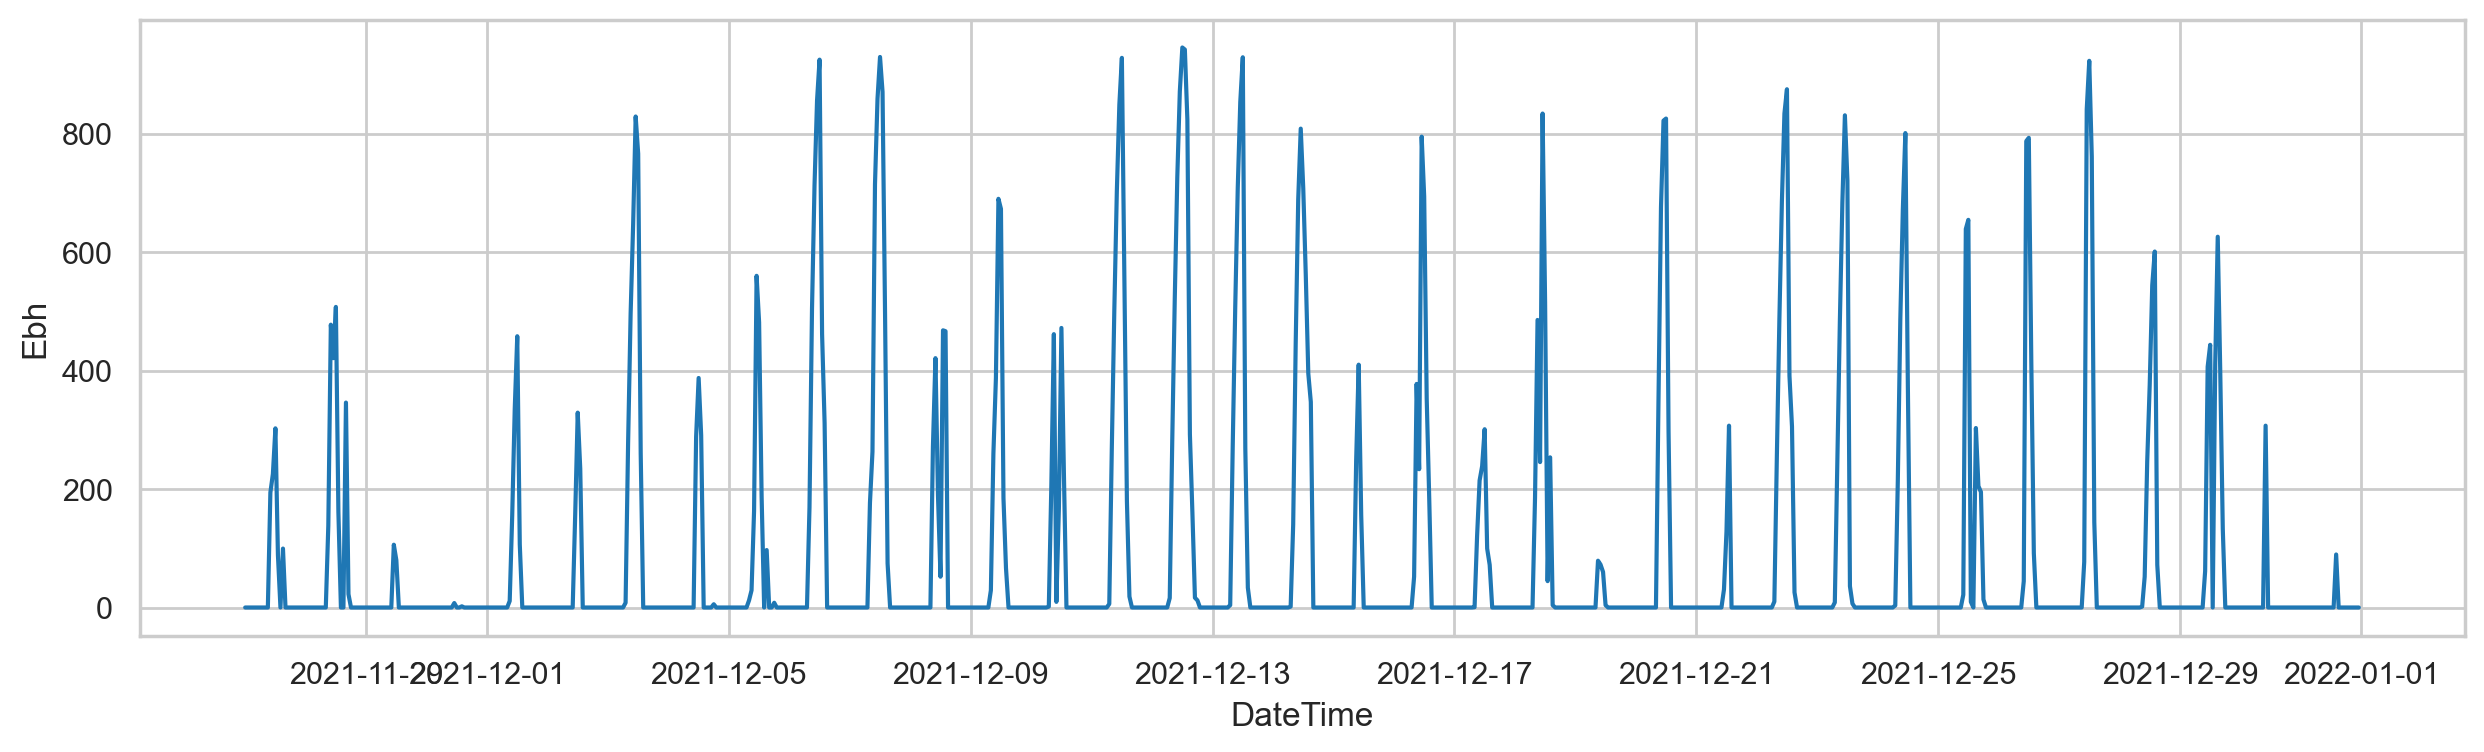

In [169]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = data.Ebh)

<AxesSubplot: xlabel='DateTime', ylabel='Dni'>

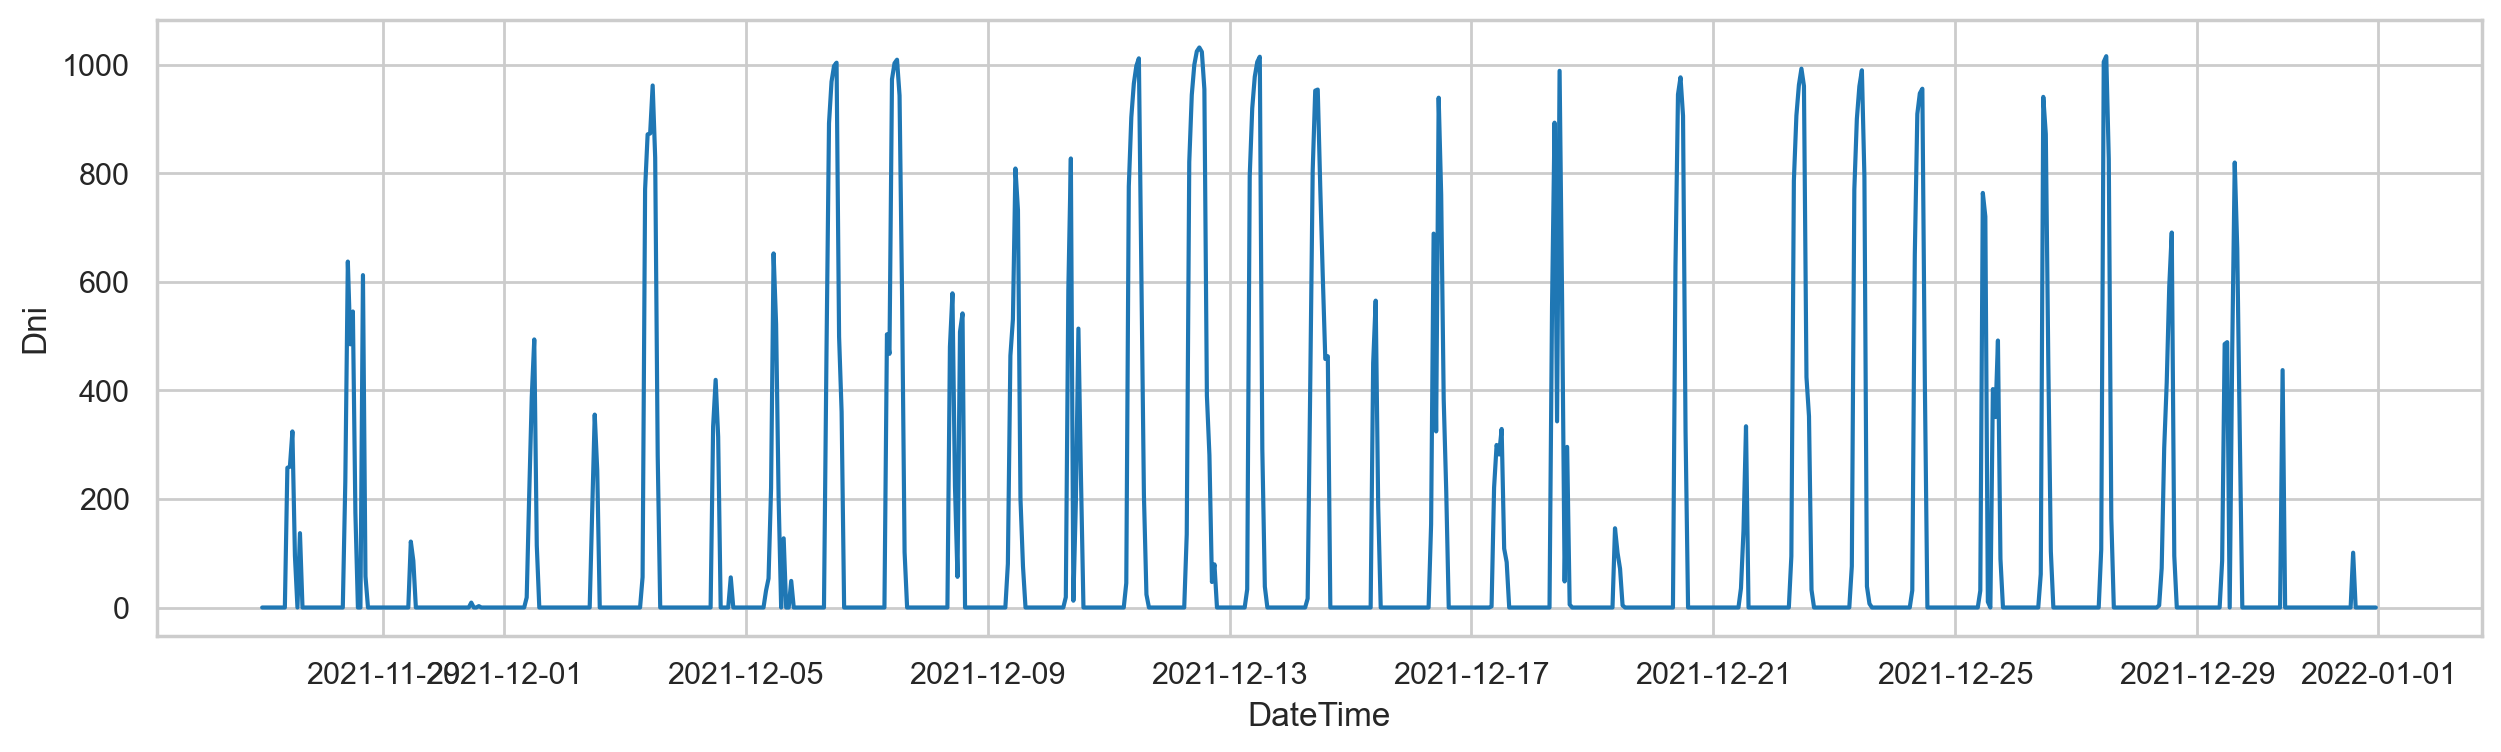

In [170]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = data.Dni)

<AxesSubplot: xlabel='DateTime', ylabel='Dhi'>

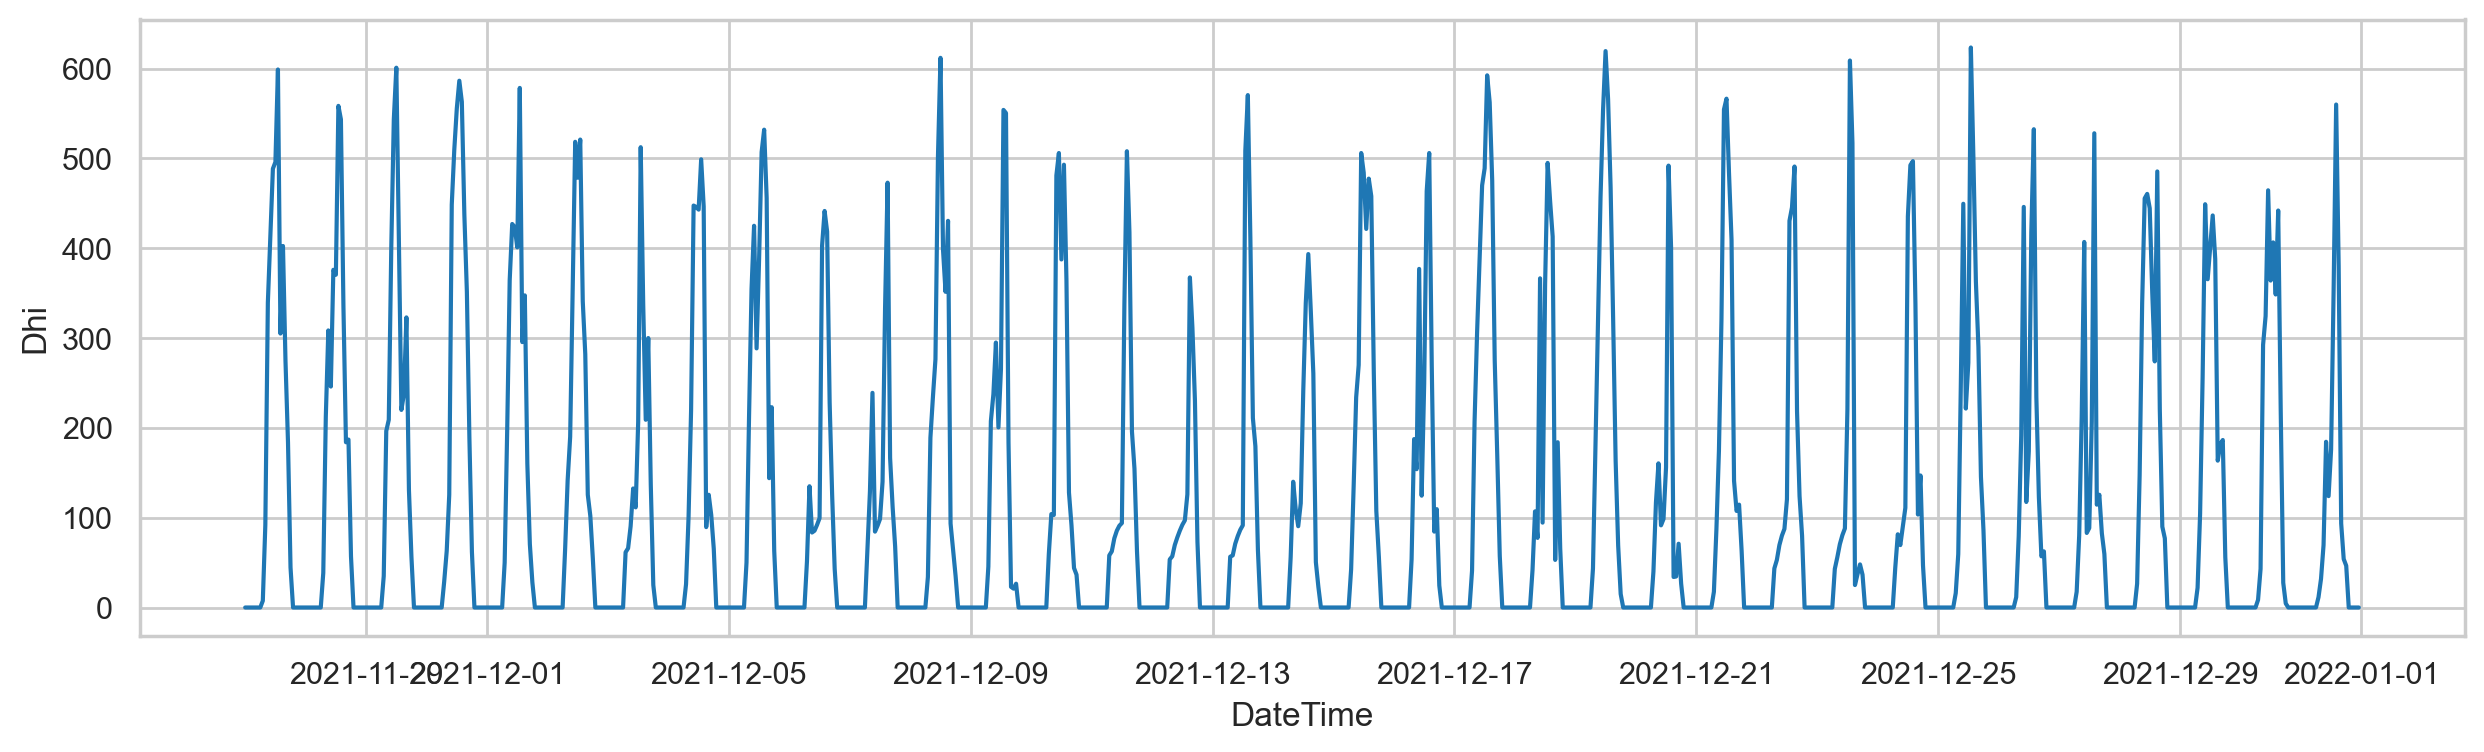

In [171]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = data.Dhi)

Text(0.5, 1.0, 'PV Generation')

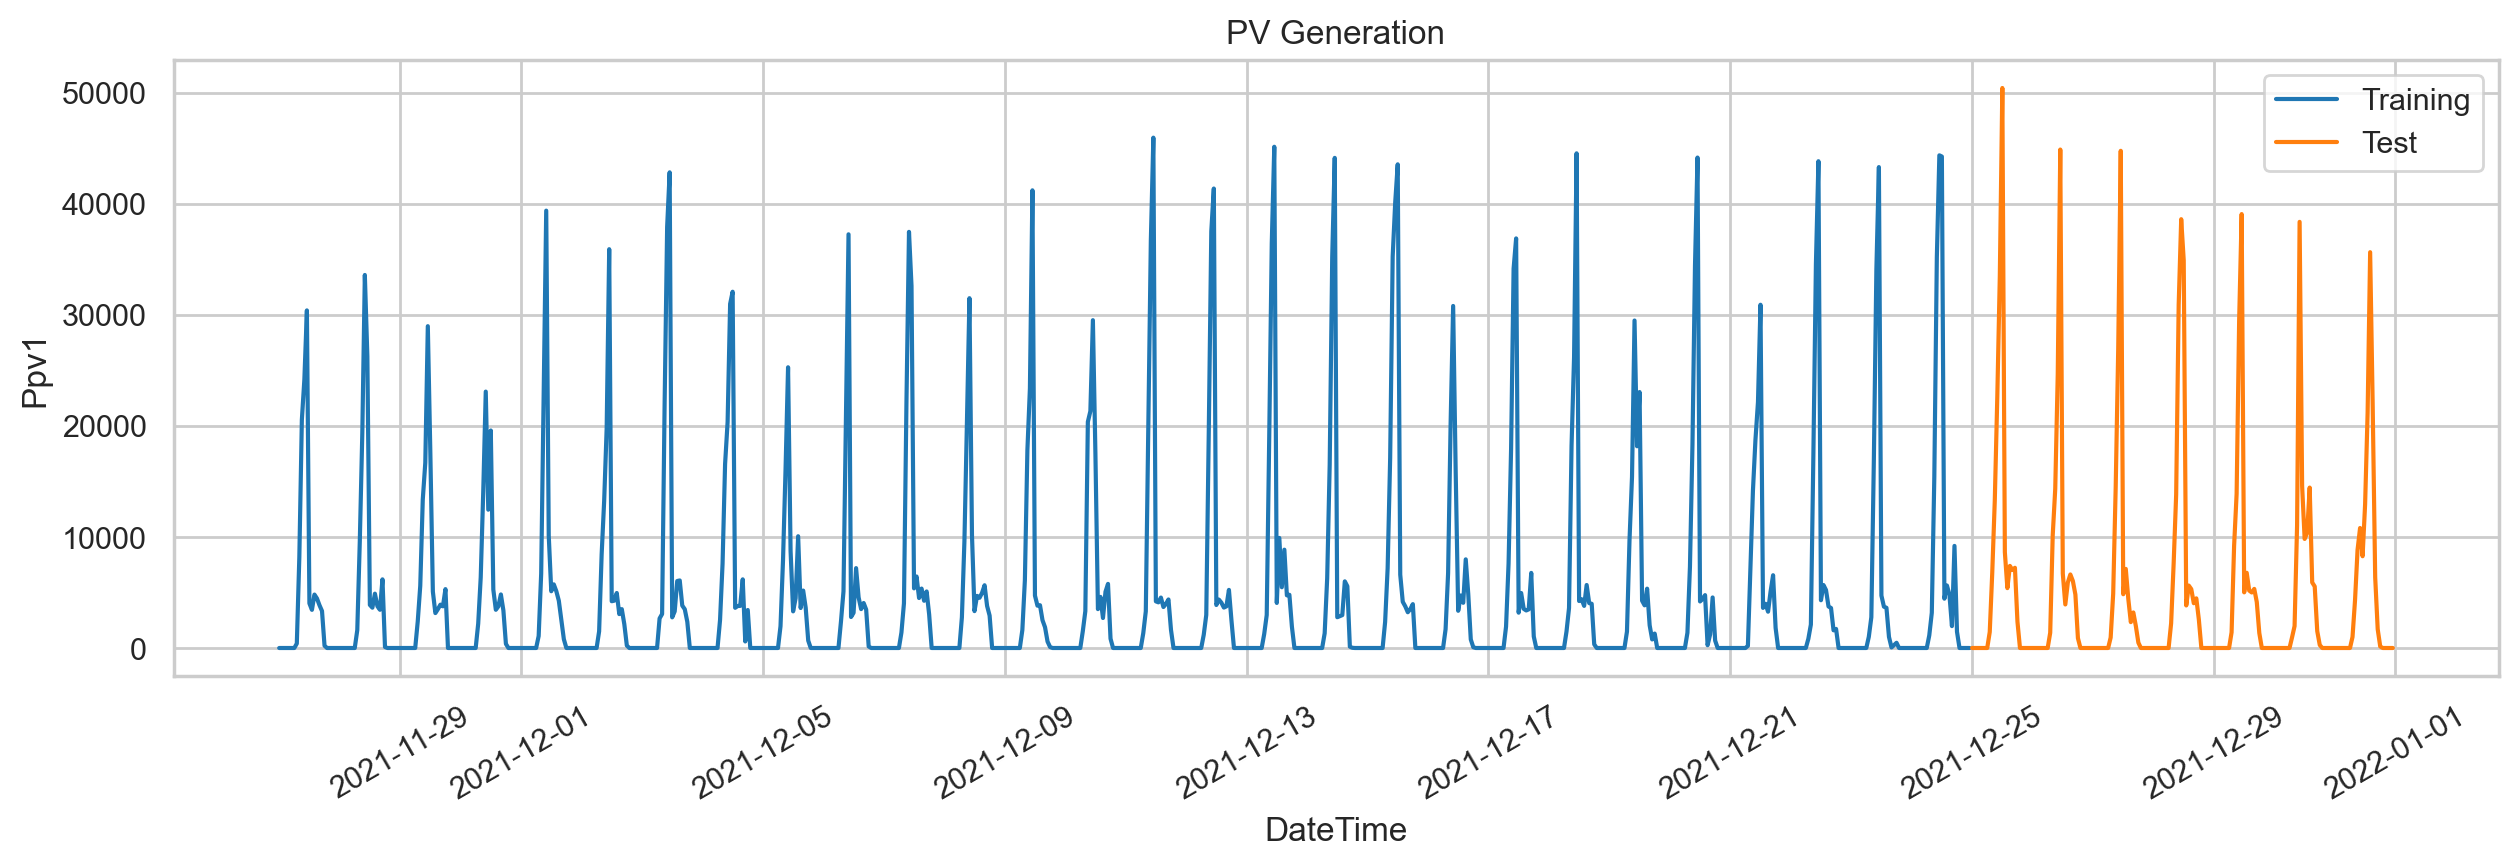

In [210]:
plt.figure(figsize=(15,4))
sns.lineplot(x = df.DateTime.iloc[-5*num_forecast_steps:-num_forecast_steps], y = df.Ppv1.iloc[-5*num_forecast_steps:-num_forecast_steps], label = 'Training')
sns.lineplot(x = df.DateTime.iloc[-num_forecast_steps:], y = df.Ppv1.iloc[-num_forecast_steps:], label = 'Test')
plt.xticks(rotation = 30)
plt.legend()
plt.title('PV Generation')

## Building and fitting the model

In [173]:
def build_model(observed_time_series):
  hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')
  ghi_effect = sts.LinearRegression(
      design_matrix=tf.reshape(data.Ghi - np.mean(data.Ghi),
                               (-1, 1)), name='ghi_effect')
  ebh_effect = sts.LinearRegression(
      design_matrix=tf.reshape(data.Ebh - np.mean(data.Ebh),
                               (-1, 1)), name='ebh_effect')                               
  dni_effect = sts.LinearRegression(
      design_matrix=tf.reshape(data.Dni - np.mean(data.Dni),
                               (-1, 1)), name='dni_effect') 
  dhi_effect = sts.LinearRegression(
      design_matrix=tf.reshape(data.Dhi - np.mean(data.Dhi),
                               (-1, 1)), name='dhi_effect') 
  cloud_effect = sts.LinearRegression(
      design_matrix=tf.reshape(data.CloudOpacity - np.mean(data.CloudOpacity),
                               (-1, 1)), name='cloud_effect')
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([hour_of_day_effect,
                   ghi_effect,
                   ebh_effect,
                   dni_effect,
                   dhi_effect,
                   cloud_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

In [174]:
pv_model = build_model(training_data.Ppv1)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=pv_model)

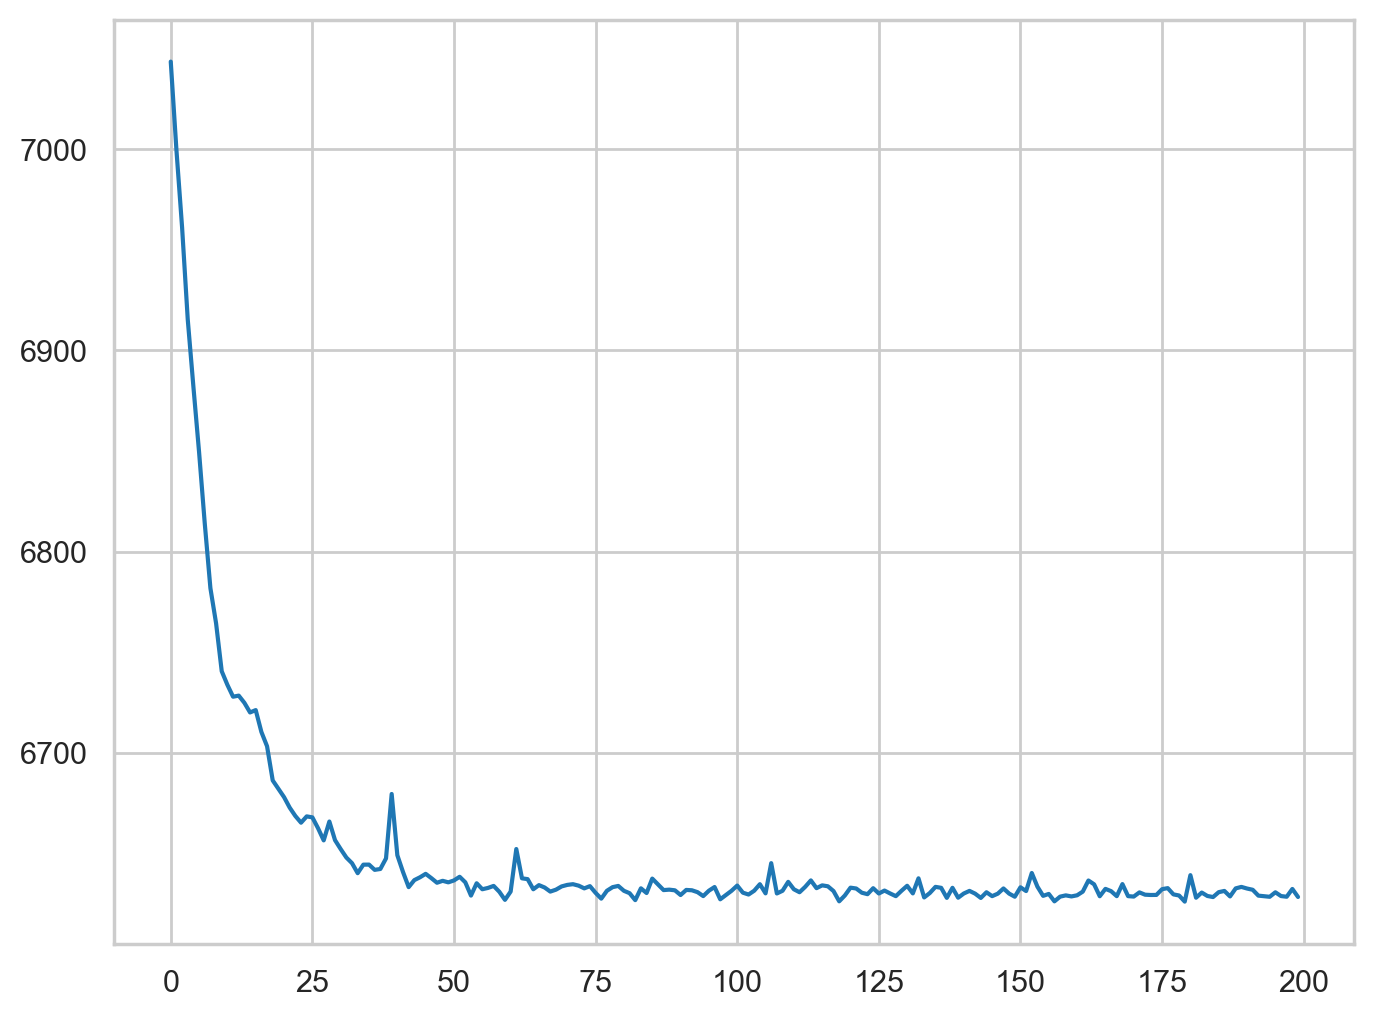

In [175]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn = pv_model.joint_distribution(
        observed_time_series = training_data.Ppv1).log_prob,
    surrogate_posterior = variational_posteriors,
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    num_steps = num_variational_steps,
    jit_compile = True)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_pv_ = variational_posteriors.sample(50)

In [176]:
print("Inferred parameters:")
for param in pv_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_pv_[param.name], axis=0),
                              np.std(q_samples_pv_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 798.9020249653811 +- 401.8721438342912
hour_of_day_effect/_drift_scale: 519.7853234253886 +- 107.02240179374867
ghi_effect/_weights: [1.25751173] +- [1.57236387]
ebh_effect/_weights: [-0.11530771] +- [1.42762448]
dni_effect/_weights: [2.53143741] +- [0.85021356]
dhi_effect/_weights: [1.69847022] +- [2.06643959]
cloud_effect/_weights: [-0.04850349] +- [5.21587755]
autoregressive/_coefficients: [0.04166777] +- [0.03077572]
autoregressive/_level_scale: 4047.197156684506 +- 109.44416574122914


## Forecasting

In [177]:
pv_forecast_dist = tfp.sts.forecast(
    model = pv_model,
    observed_time_series = training_data.Ppv1,
    parameter_samples = q_samples_pv_,
    num_steps_forecast = num_forecast_steps)

In [178]:
num_samples=10

(
    pv_forecast_mean,
    pv_forecast_scale,
    pv_forecast_samples
) = (
    pv_forecast_dist.mean().numpy()[..., 0],
    pv_forecast_dist.stddev().numpy()[..., 0],
    pv_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

In [179]:
pv_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
pv_fmt = mdates.DateFormatter('%d %b %Y')

In [180]:
training_data.DateTime

7920   2021-11-27 00:00:00
7921   2021-11-27 01:00:00
7922   2021-11-27 02:00:00
7923   2021-11-27 03:00:00
7924   2021-11-27 04:00:00
               ...        
8587   2021-12-24 19:00:00
8588   2021-12-24 20:00:00
8589   2021-12-24 21:00:00
8590   2021-12-24 22:00:00
8591   2021-12-24 23:00:00
Name: DateTime, Length: 672, dtype: datetime64[ns]

In [181]:
len(data.Ppv1)

840

In [182]:
num_steps_forecast = pv_forecast_mean.shape[-1]
num_steps_forecast

168

In [183]:
num_steps_train = len(data.Ppv1) - pv_forecast_mean.shape[-1]
num_steps_train

672

In [184]:
x = data.DateTime
x

7920   2021-11-27 00:00:00
7921   2021-11-27 01:00:00
7922   2021-11-27 02:00:00
7923   2021-11-27 03:00:00
7924   2021-11-27 04:00:00
               ...        
8755   2021-12-31 19:00:00
8756   2021-12-31 20:00:00
8757   2021-12-31 21:00:00
8758   2021-12-31 22:00:00
8759   2021-12-31 23:00:00
Name: DateTime, Length: 840, dtype: datetime64[ns]

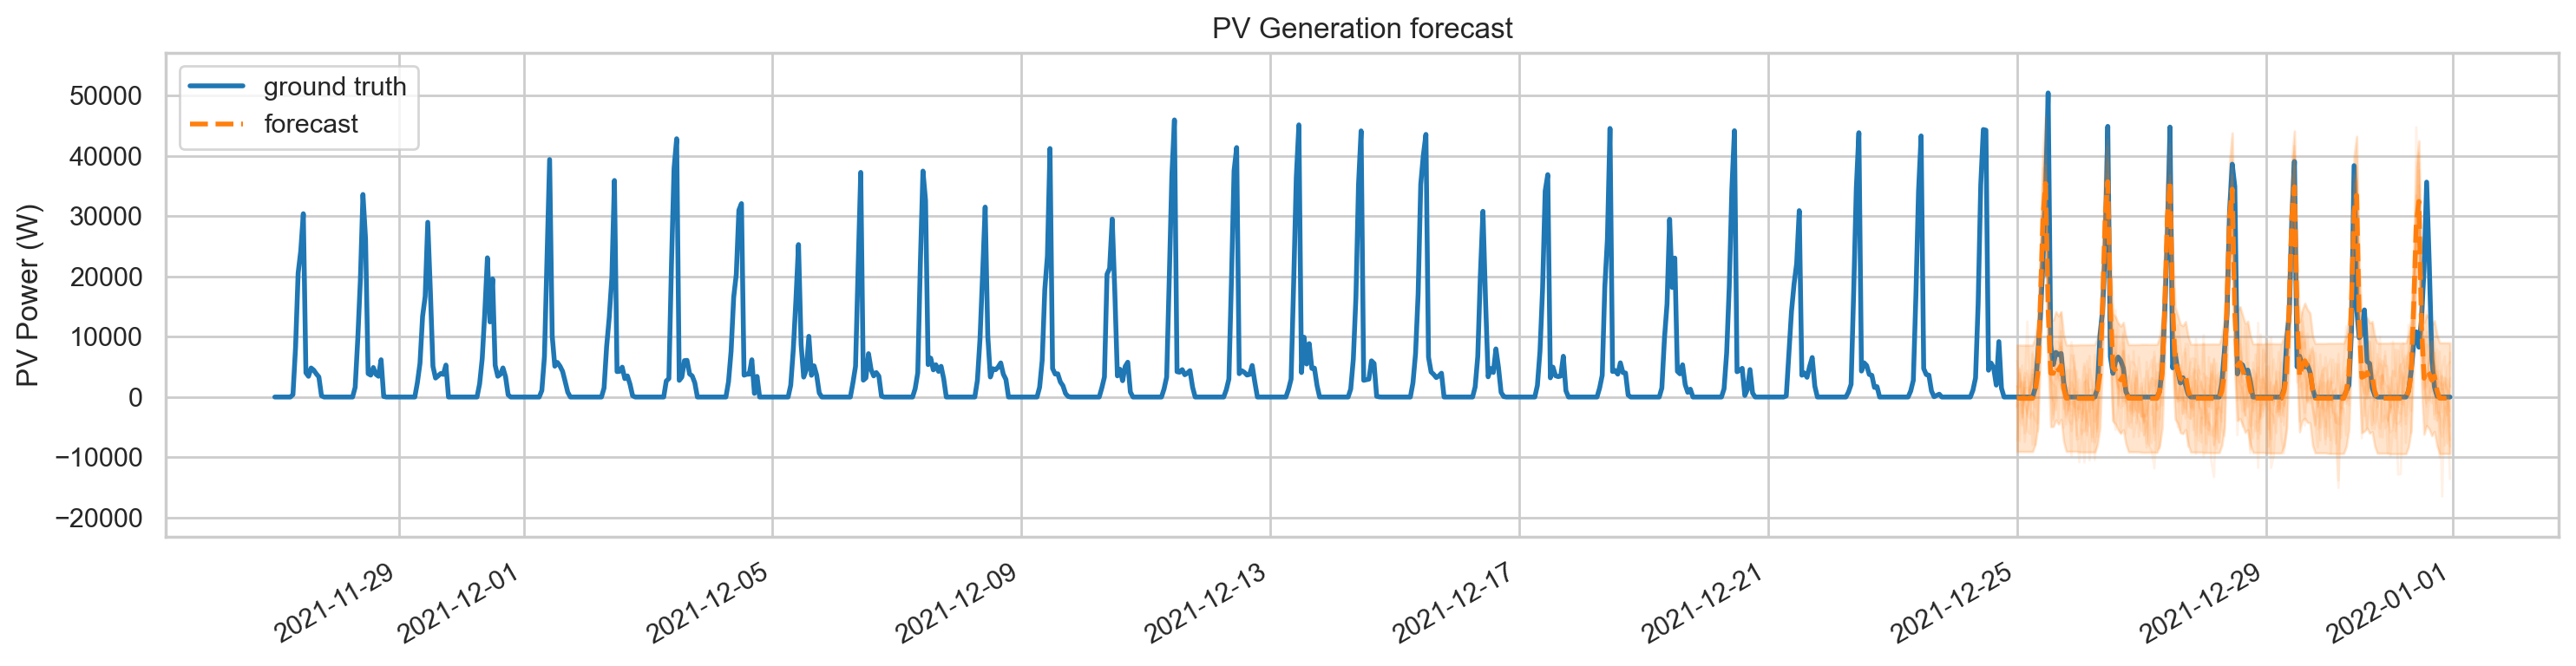

In [205]:
fig, ax = plot_forecast(data.DateTime, data.Ppv1,
                        pv_forecast_mean,
                        pv_forecast_scale,
                        pv_forecast_samples,
                        title="PV Generation forecast",
                        x_locator=pv_loc, x_formatter=pv_fmt)
ax.set_ylabel('PV Power (W)')
fig.tight_layout()

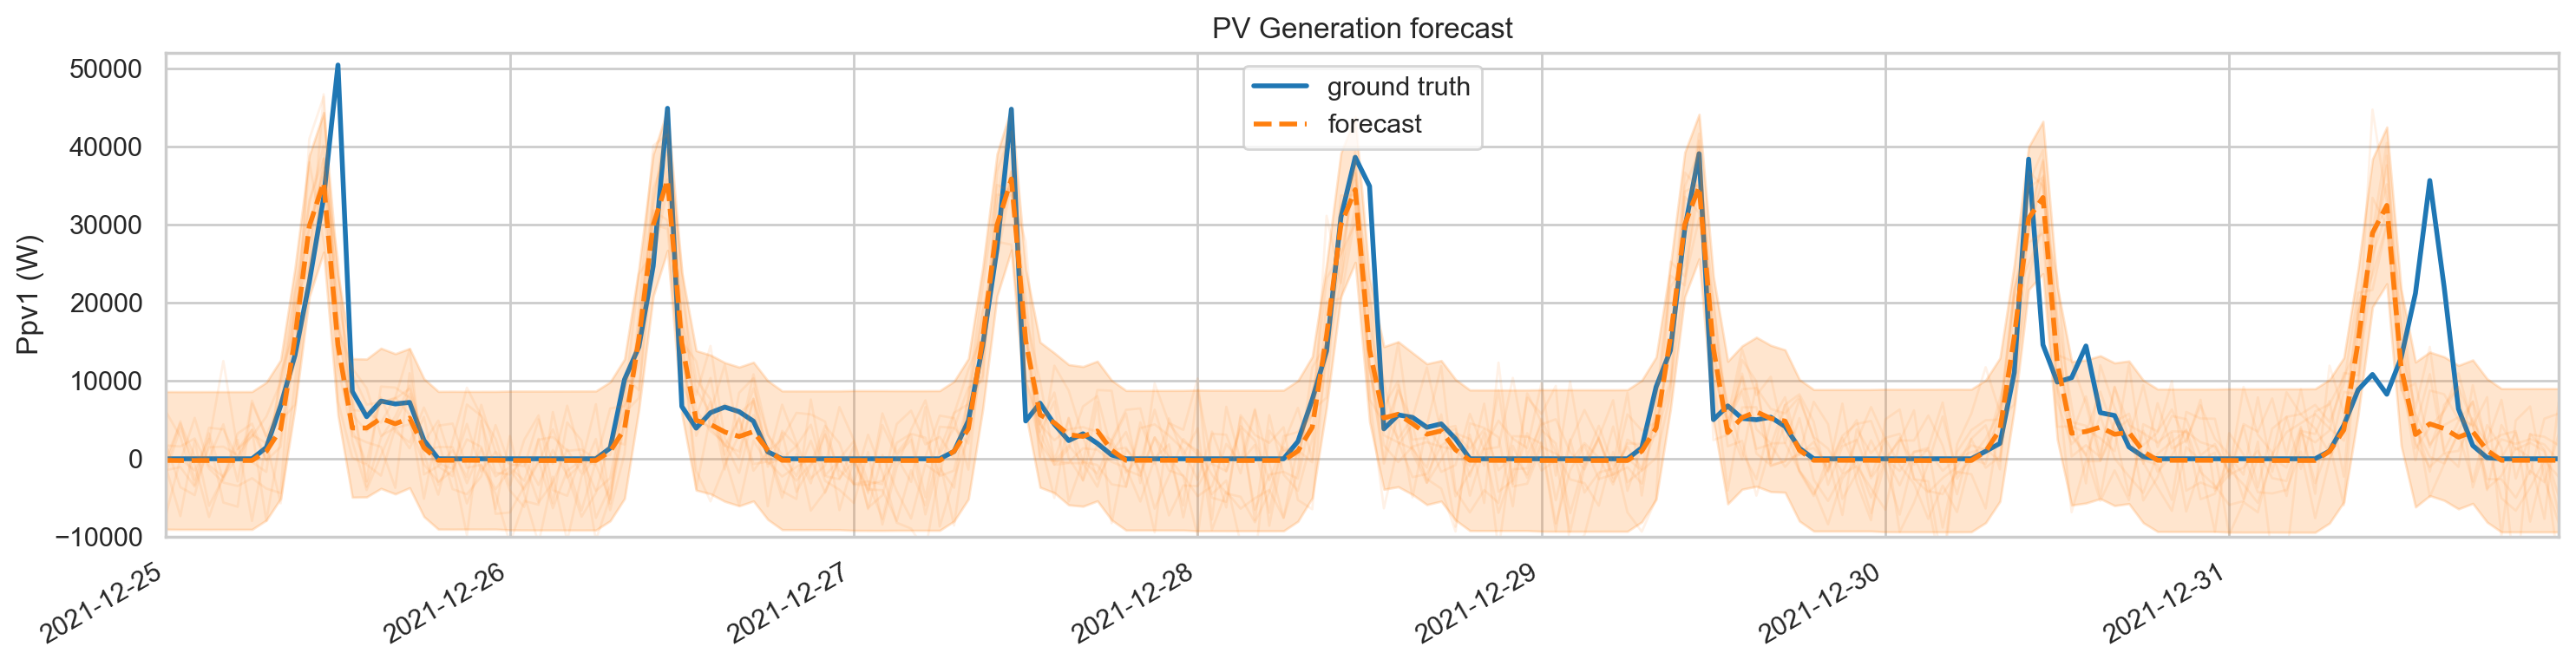

In [206]:
fig, ax = plot_forecast(data.DateTime, data.Ppv1,
                        pv_forecast_mean,
                        pv_forecast_scale,
                        pv_forecast_samples,
                        title="PV Generation forecast",
                        x_locator=pv_loc, x_formatter=pv_fmt)
ax.set_xlim([data.DateTime.iloc[num_steps_train], data.DateTime.iloc[len(data)-1]])
ax.set_ylim([-10000, 52000])
ax.set_ylabel('Ppv1 (W)')
fig.tight_layout()

## Decomposition

In [187]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    pv_model,
    observed_time_series=training_data.Ppv1,
    parameter_samples=q_samples_pv_)

forecast_component_dists = sts.decompose_forecast_by_component(
    pv_model,
    forecast_dist=pv_forecast_dist,
    parameter_samples=q_samples_pv_)

In [188]:
pv_component_means_, pv_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    pv_forecast_component_means_,
    pv_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

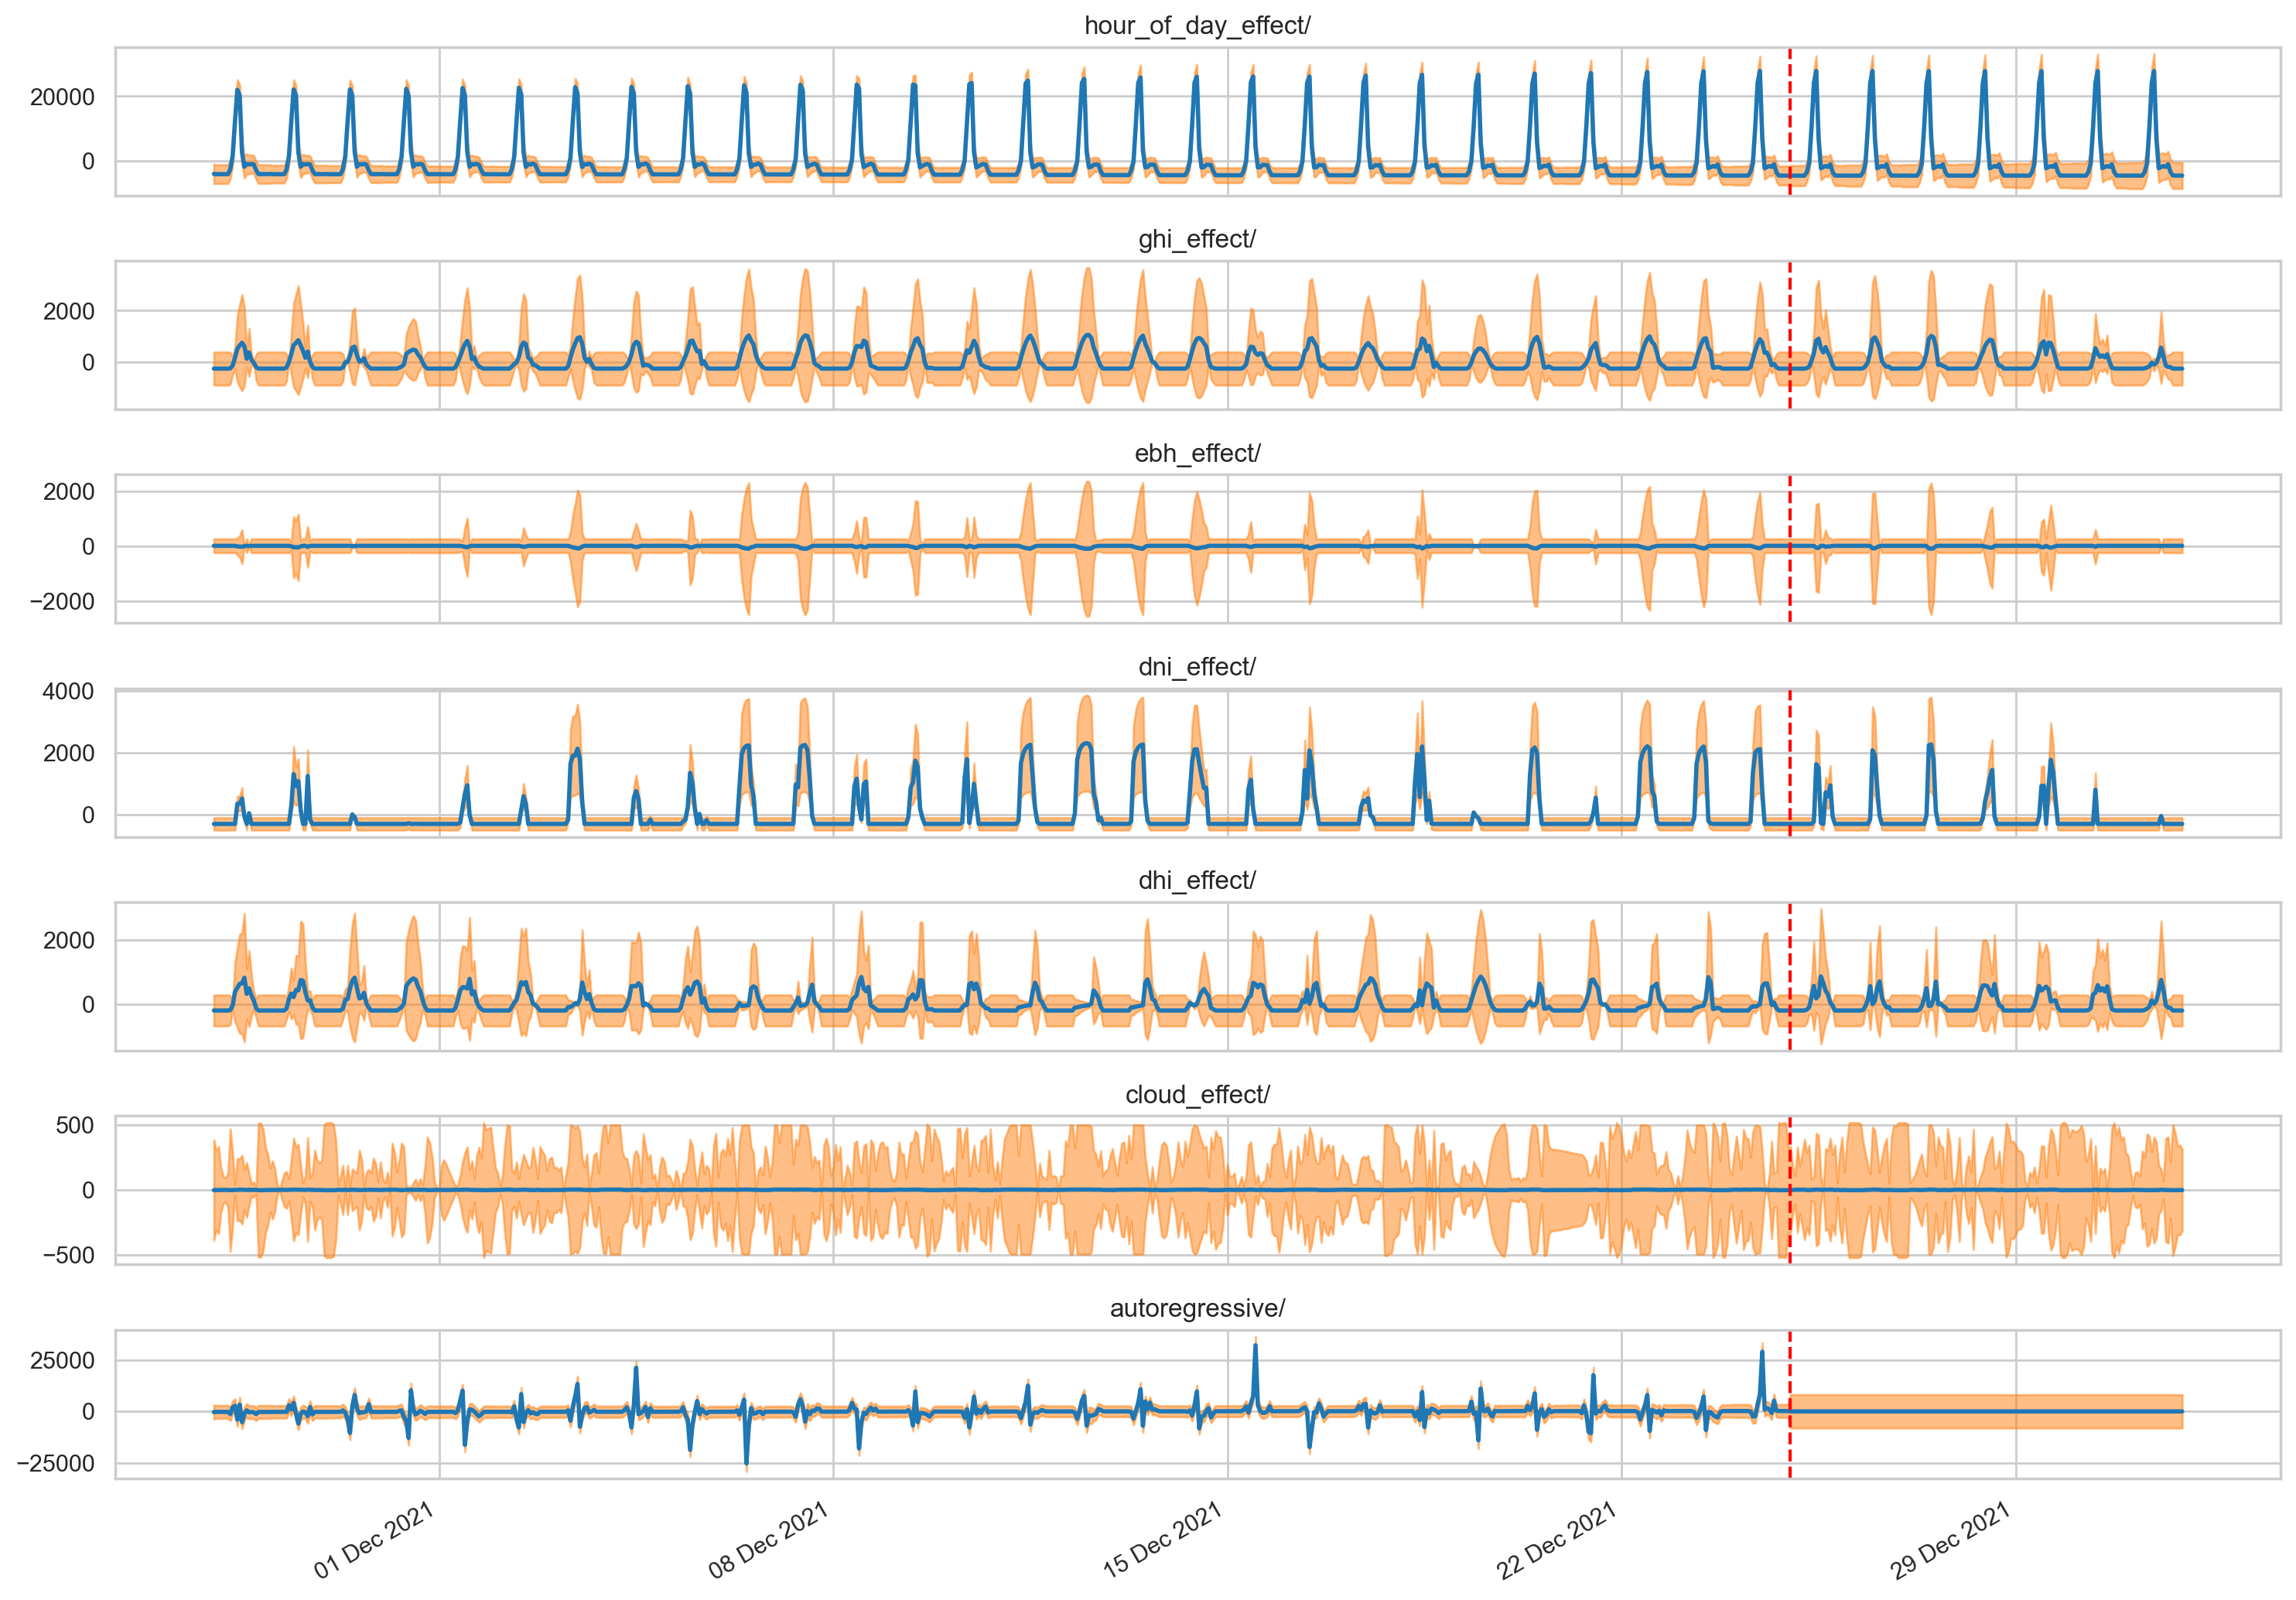

In [189]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in pv_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      pv_component_means_[k],
      pv_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      pv_component_stddevs_[k],
      pv_forecast_component_stddevs_[k]], axis=-1)

fig, axes = plot_components(
  data.DateTime,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=pv_loc, x_formatter=pv_fmt)
for ax in axes.values():
  ax.axvline(data.DateTime.iloc[-num_forecast_steps], linestyle="--", color='red')

## Single-step predictions

In [190]:
pv_one_step_dist = sts.one_step_predictive(
    pv_model,
    observed_time_series=data.Ppv1,
    parameter_samples=q_samples_pv_)

pv_one_step_mean, pv_one_step_scale = (
    pv_one_step_dist.mean().numpy(), pv_one_step_dist.stddev().numpy())

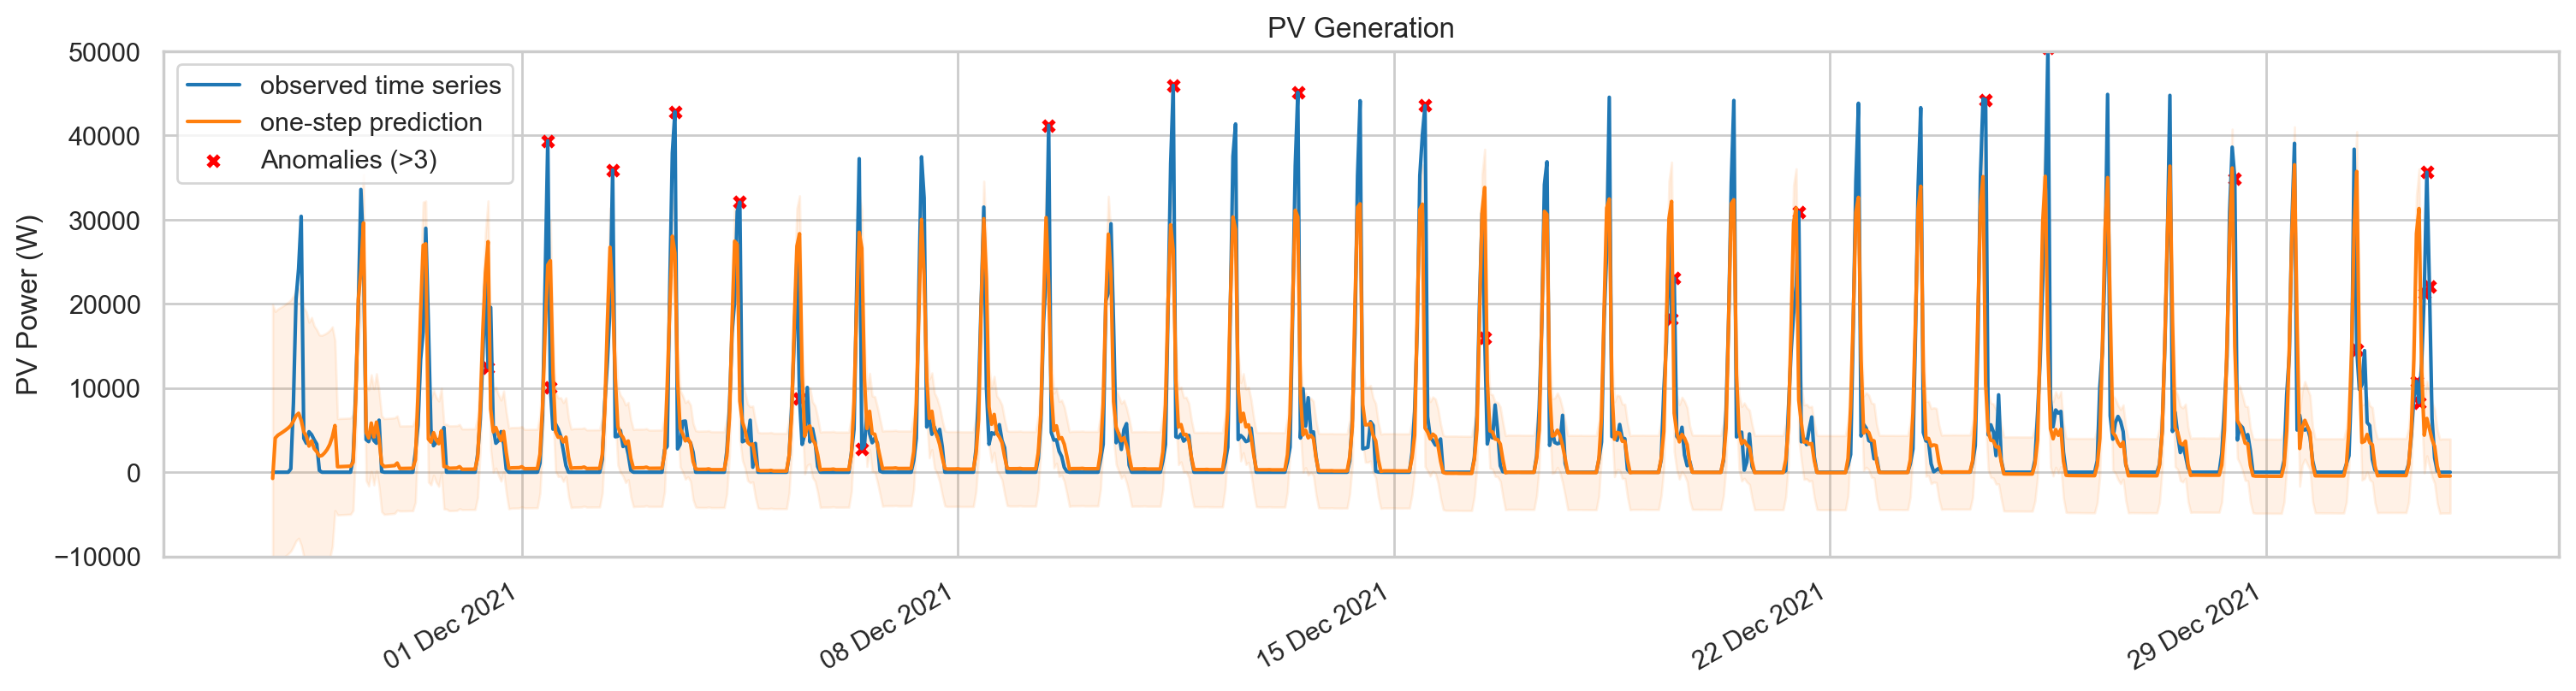

In [211]:
fig, ax = plot_one_step_predictive(
    data.DateTime, data.Ppv1,
    pv_one_step_mean, pv_one_step_scale,
    x_locator=pv_loc, x_formatter=pv_fmt)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((data.Ppv1 - pv_one_step_mean) /
                 pv_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(data.DateTime[anomalies],
           data.Ppv1[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3)")
# ax.plot(data.DateTime, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.set_ylabel('PV Power (W)')
ax.legend()
ax.set_ylim([-10000, 50000])
plt.title('PV Generation')
plt.show()

## Z-scores

Z-scores describe the position of a raw score in terms of its distance from the mean when measured in standard deviation units.

$$Z = \frac{x - \mu}{\sigma}$$

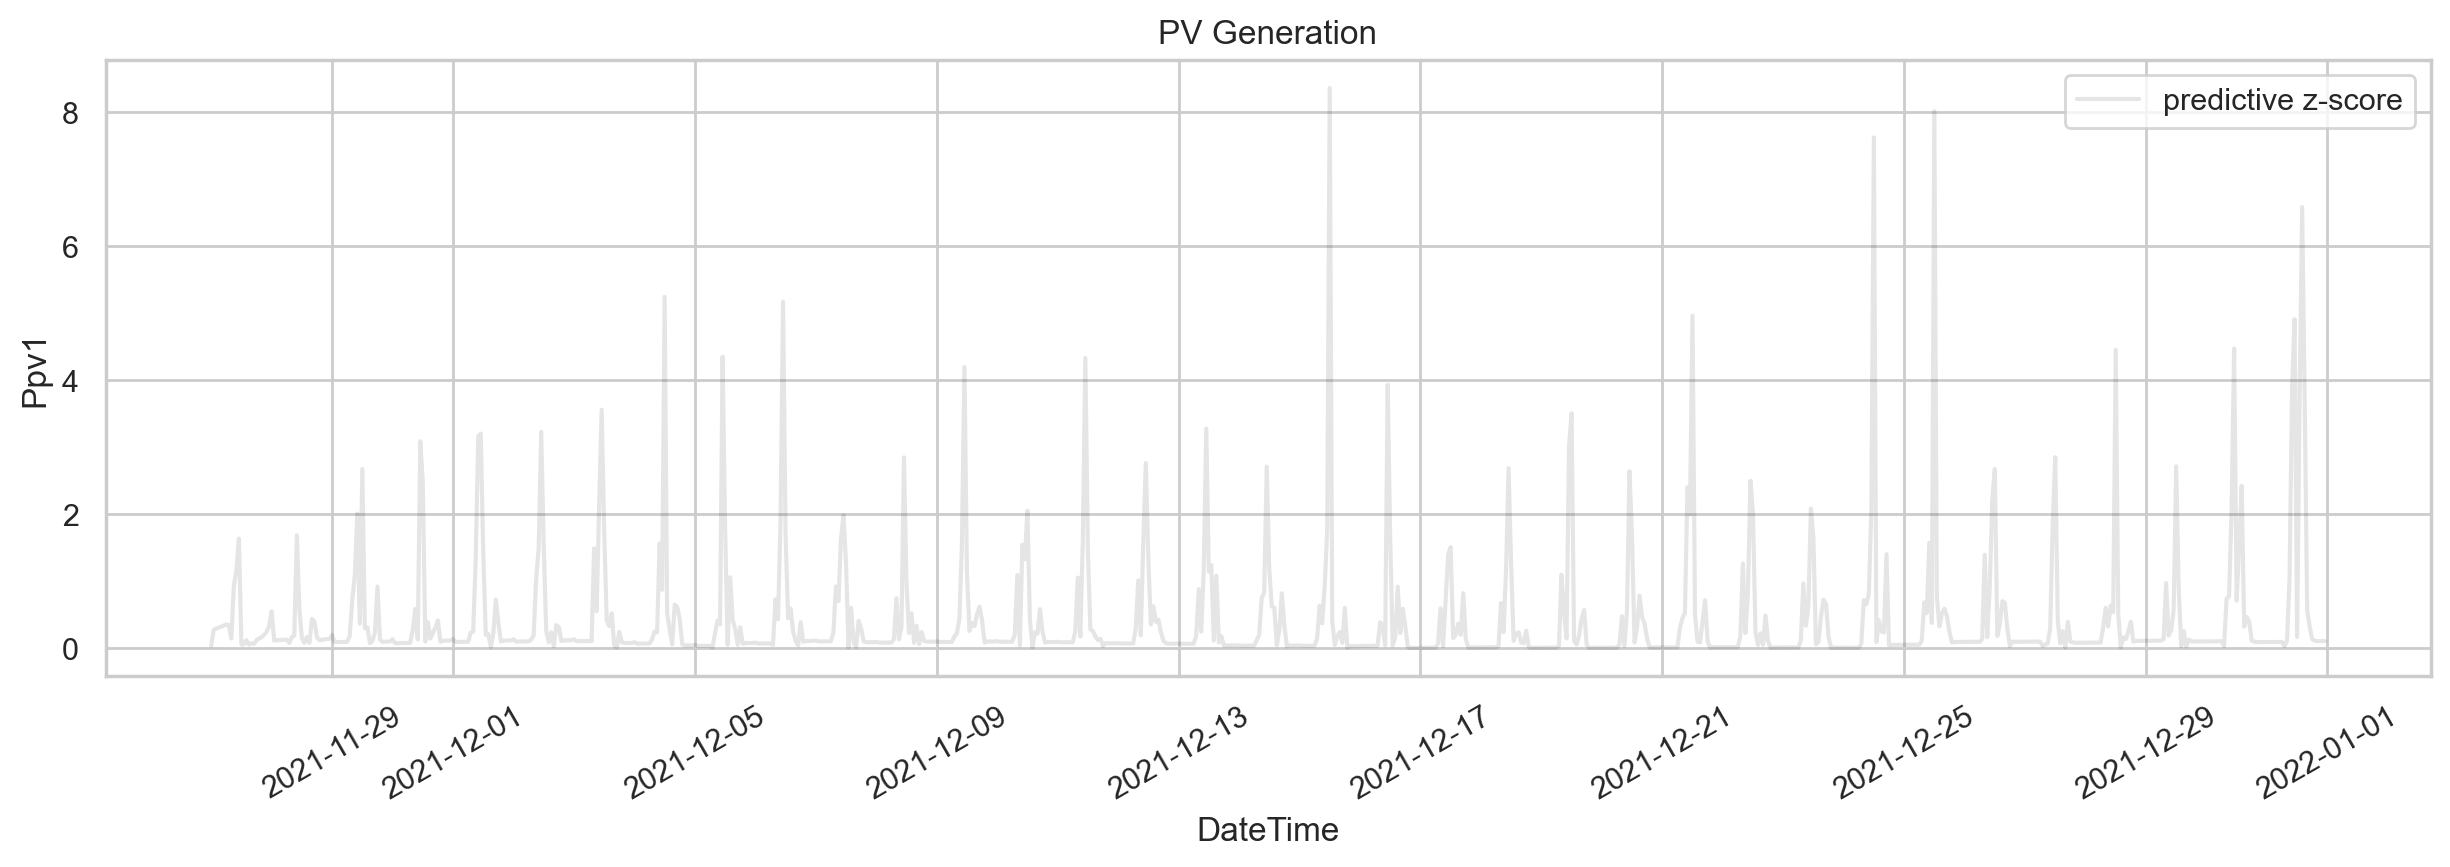

In [213]:
plt.figure(figsize=(15,4))
sns.lineplot(x = data.DateTime, y = zscores, color="black", alpha=0.1, label='predictive z-score')
plt.xticks(rotation = 30)
plt.legend()
plt.title('PV Generation')
plt.show()

In [193]:
zscores.mean()

0.4389340008020843

In [194]:
len(zscores[zscores < 1])/len(zscores) # Proportion of one-step predictions within 1 standard deviation from the true value

0.8833333333333333

In [195]:
len(zscores[zscores < 2])/len(zscores) # Proportion of one-step predictions within 2 standard deviations from the true value

0.9452380952380952

In [196]:
len(zscores[zscores < 3])/len(zscores) # Proportion of one-step predictions within 3 standard deviatios from the true value

0.9702380952380952

## Prediction Accuracy

In [197]:
forecast_mean = pv_forecast_mean.mean()
forecast_std = pv_forecast_mean.std()

pv_forecast_mean_standardised = (pv_forecast_mean - forecast_mean) / forecast_std # Standardise Data

In [198]:
test_data_mean = data.Ppv1.iloc[-num_forecast_steps:].mean()
test_data_std = data.Ppv1.iloc[-num_forecast_steps:].std()

test_data_standardised = (data.Ppv1.iloc[-num_forecast_steps:] - test_data_mean) / test_data_std # Standardise Data

## Standardised Mean Absolute Error

In [199]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_data_standardised, pv_forecast_mean_standardised)

0.2357384472643646

## Mean Absolute Error (in Watts)

In [200]:
mean_absolute_error(data.Ppv1.iloc[-num_forecast_steps:], pv_forecast_mean)

2388.6244830975934